# **Libraries**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from datetime import datetime

# **utils**

In [7]:
def merge_dataframes(dataframes_dict):
    """
    Merge dataframes from a dictionary into a single dataframe.

    Parameters:
    - dataframes_dict: A dictionary where keys are names and values are dataframes.

    Returns:
    - Merged dataframe with a datetime index and columns from all input dataframes.
    
    # Example usage:
    dataframes_dict = {
        'actual': df_actual,
        'forecast_1': df_forecast_1,
        'forecast_2': df_forecast_2
    }

    merged_dataframe = merge_dataframes(dataframes_dict)
    """
    # Concatenate dataframes along the columns axis
    merged_df = pd.concat(dataframes_dict.values(), axis=1)

    # Ensure mutual datetime index
    merged_df = merged_df.groupby(level=0, axis=1).first()

    return merged_df



In [8]:
# # test 
# # Define sample dataframes
# date_range = pd.date_range(start='2024-01-01', end='2024-01-03')
# df_actual = pd.DataFrame({'actual_data': [1, 2, 3]}, index=date_range)
# df_forecast_1 = pd.DataFrame({'forecast_data_1': [4, 5, 6]}, index=date_range)
# df_forecast_2 = pd.DataFrame({'forecast_data_2': [7, 8, 9]}, index=date_range)
# df_forecast_3 = pd.DataFrame({'forecast_data_3': [10, 11, 12]}, index=date_range)  # Additional forecast dataframe

# # Create a dictionary of dataframes
# dataframes_dict = {
#     'actual': df_actual,
#     'forecast_1': df_forecast_1,
#     'forecast_2': df_forecast_2,
#     'forecast_3': df_forecast_3  # Adding additional forecast dataframe
# }

# # Test the function
# merged_dataframe = merge_dataframes(dataframes_dict)
# print(merged_dataframe)

In [9]:
import matplotlib.pyplot as plt

def plot_scatter(df, target_column):
    """
    Plots scatter plots between each predictor column and the target column in a DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing predictor and target columns.
    - target_column (str): The name of the target column.

    Returns:
    - None
    """
    predictors = [col for col in df.columns if col != target_column]

    for predictor in predictors:
        plt.figure(figsize=(8, 6))
        plt.scatter(df[predictor], df[target_column], alpha=0.5)
        plt.title(f'{predictor} vs {target_column}')
        plt.xlabel(predictor)
        plt.ylabel(target_column)
        plt.grid(True)
        plt.show()


# **modelling**

## **forecast metrics**

In [10]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_smape(y_true, y_pred):
    return (np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100)

In [11]:
def calculate_forecast_bias(pred_series, actual_series):
    """ 
    Forecast Bias (FB)

    Parameters
        - actual_series (pd.Series): The time series of actual values  
        - pred_series (pd.Series): The time series of predicted values.

    Returns
        - float: The Forecast Bias 
    """
    
    y_true, y_pred = actual_series, pred_series
    
    y_true_sum, y_pred_sum = np.sum(y_true), np.sum(y_pred)
    # raise_if_not(y_true_sum > 0, 'The series of actual value cannot sum to zero when computing OPE.', logger)
    
    # return ((y_true_sum - y_pred_sum) / y_true_sum) * 100.
    
    return ((y_pred_sum - y_true_sum) / len(y_true))

## **LR**

In [12]:
import statsmodels.api as sm
def train_linear_regression(df, target_column, plot_flag=False):
    """
    Train a Linear Regression model on a dataframe.

    Parameters:
    - df: The input dataframe.
    - target_column: The target column to train the model on.
    - plot_flag: A flag indicating whether to plot the results.

    Returns:
    - Trained Linear Regression model.
    - Dataframe with a new column 'blended_forecast' containing the predicted values of the model.
    - Dataframe containing the evaluation metric values for each column against the target.
    """
    # Extract features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    blended_forecast = model.predict(X)

    # Add blended forecast to the dataframe
    df_with_forecast = df.copy()
    df_with_forecast['blended_predicted_values'] = blended_forecast

    # Calculate evaluation metrics
    metrics_dict = {}
    eval_columns = df_with_forecast.columns.tolist()
    eval_columns.remove(target_column)
    for col in eval_columns:
        mse = mean_squared_error(df_with_forecast[col], df[target_column])
        mae = mean_absolute_error(df_with_forecast[col], df[target_column])
        rmse = calculate_rmse(df_with_forecast[col], df[target_column])
        mape = calculate_mape(df_with_forecast[col], df[target_column])
        smape = calculate_smape(df_with_forecast[col], df[target_column])
        forecast_bias = calculate_forecast_bias(df_with_forecast[col], df[target_column])
        metrics_dict[col] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'SMAPE': smape, 'Forecast Bias': round(forecast_bias, 2)}

    metrics_df = pd.DataFrame(metrics_dict).T

    # Plot if plot_flag is True
    if plot_flag:
        plt.figure(figsize=(20, 6))
        plt.plot(df[target_column], label='Actual')
        plt.plot(df_with_forecast['blended_predicted_values'], label='Blended Predicted')
        for col in df.columns:
            if col != target_column:
                plt.plot(df[col], label=col, alpha=0.7)
        plt.legend()
        plt.title('Actual vs Predicted vs Predictors')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.show()

    return model, df_with_forecast, metrics_df


In [13]:
# test 
# Create synthetic dataset
# np.random.seed(0)
# num_samples = 100
# data = {
#     'feature1': np.random.rand(num_samples),
#     'feature2': np.random.rand(num_samples),
#     'target': np.random.rand(num_samples)
# }
# df = pd.DataFrame(data)

# # Train linear regression model
# model, df_with_forecast, metrics_df = train_linear_regression(df, 'target', plot_flag=True)

# # Print evaluation metrics
# print("Evaluation Metrics:")
# print(metrics_df)

## **Ridge**

In [14]:
def train_ridge_regression(df, target_column, alpha=1.0, plot_flag=False):
    # Extract features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Train Linear Regression model
    model = Ridge(alpha=alpha)
    model.fit(X, y)

    # Make predictions
    blended_forecast = model.predict(X)

    # Add blended forecast to the dataframe
    df_with_forecast = df.copy()
    df_with_forecast['blended_predicted_values'] = blended_forecast

    # Calculate evaluation metrics
    metrics_dict = {}
    eval_columns = df_with_forecast.columns.tolist()
    eval_columns.remove(target_column)
    for col in eval_columns:
        mse = mean_squared_error(df_with_forecast[col], df[target_column])
        mae = mean_absolute_error(df_with_forecast[col], df[target_column])
        rmse = calculate_rmse(df_with_forecast[col], df[target_column])
        mape = calculate_mape(df_with_forecast[col], df[target_column])
        smape = calculate_smape(df_with_forecast[col], df[target_column])
        forecast_bias = calculate_forecast_bias(df_with_forecast[col], df[target_column])
        metrics_dict[col] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'SMAPE': smape, 'Forecast Bias': round(forecast_bias, 2)}


    metrics_df = pd.DataFrame(metrics_dict).T

    # Plot if plot_flag is True
    if plot_flag:
        plt.figure(figsize=(20, 6))
        plt.plot(df[target_column], label='Actual')
        plt.plot(df_with_forecast['blended_predicted_values'], label='Blended Predicted')
        for col in df.columns:
            if col != target_column:
                plt.plot(df[col], label=col, alpha=0.7)
        plt.legend()
        plt.title('Actual vs Predicted vs Predictors')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.show()

    return model, df_with_forecast, metrics_df


## **WLS**

In [15]:
def residual_analysis_with_predictors(df, target_column, square=False):
    # Extract features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Train Weighted Least Squares Linear Regression model
    # fit linear regression model
    fit = sm.OLS(y, sm.add_constant(X)).fit()
    
    # Calculate residuals
    residuals = fit.resid

    # Dictionary to store fitted values for each predictor
    fitted_values = {}

    # Iterate over each predictor
    for col in X.columns:
        if square:
            # Plot squared residuals against predictor
            squared_residuals = residuals ** 2
            plt.figure(figsize=(8, 6))
            plt.scatter(X[col], squared_residuals)
            plt.title(f'Squared Residual Plot against {col}')
            plt.xlabel(col)
            plt.ylabel('Squared Residuals')
            plt.grid(True)
            plt.show()

            # Regress squared residuals against predictor
            model = sm.OLS(squared_residuals, sm.add_constant(X[col])).fit()

        else:
            # Plot residual plot against each predictor
            plt.figure(figsize=(8, 6))
            plt.scatter(X[col], residuals)
            plt.title(f'Residual Plot against {col}')
            plt.xlabel(col)
            plt.ylabel('Residuals')
            plt.grid(True)
            plt.show()

            # Regress absolute values of residuals against predictor
            abs_residuals = np.abs(residuals)
            model = sm.OLS(abs_residuals, sm.add_constant(X[col])).fit()

        # Store fitted values
        fitted_values[col] = model.fittedvalues

    return fitted_values

#========================================================

def residual_analysis_with_fitted(df, target_column, square=False):
    # Extract features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Train Weighted Least Squares Linear Regression model
    # fit linear regression model
    fit = sm.OLS(y, sm.add_constant(X)).fit()
    
    # Calculate residuals
    residuals = fit.resid

    if square:
        # Plot squared residuals against predictor
        squared_residuals = residuals ** 2
        plt.figure(figsize=(8, 6))
        plt.scatter(fit.fittedvalues, squared_residuals)
        plt.title('Squared Residual Plot against Fitted Values')
        plt.xlabel('Fitted Values')
        plt.ylabel('Squared Residuals')
        plt.grid(True)
        plt.show()

        # Regress squared residuals against fitted values
        model = sm.OLS(squared_residuals, sm.add_constant(fit.fittedvalues)).fit()
    else:
        # Plot residual plot against each predictor
        plt.figure(figsize=(8, 6))
        plt.scatter(fit.fittedvalues, residuals)
        plt.title('Residual Plot against Fitted Values')
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.grid(True)
        plt.show()

        # Regress absolute values of residuals against fitted values
        abs_residuals = np.abs(residuals)
        model = sm.OLS(abs_residuals, sm.add_constant(fit.fittedvalues)).fit()

    # Store fitted values
    fitted_values = model.fittedvalues

    return {'fitted_values': fitted_values}


# =========================================================
def train_weighted_linear_regression(df, target_column, weight, plot_flag=False):
    """
    Train a Linear Regression model on a dataframe using Weighted Least Squares (WLS).

    Parameters:
    - df: The input dataframe.
    - target_column: The target column to train the model on.
    - plot_flag: A flag indicating whether to plot the results.

    Returns:
    - Trained Linear Regression model.
    - Dataframe with a new column 'blended_forecast' containing the predicted values of the model.
    - Dataframe containing the evaluation metric values for each column against the target.
    """
    # Extract features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]


    # Train Weighted Least Squares 
    #define weights to use wt = 1/sigma**2
    wt = 1.0/weight

    #fit weighted least squares regression model
    fit_wls = sm.WLS(y, X, weights=wt).fit()

    # Make predictions
    blended_forecast = fit_wls.predict(X)

    # Add blended forecast to the dataframe
    df_with_forecast = df.copy()
    df_with_forecast['blended_predicted_values'] = blended_forecast

    # Calculate evaluation metrics
    metrics_dict = {}
    eval_columns = df_with_forecast.columns.tolist()
    eval_columns.remove(target_column)
    for col in eval_columns:
        mse = mean_squared_error(df_with_forecast[col], df[target_column])
        mae = mean_absolute_error(df_with_forecast[col], df[target_column])
        rmse = calculate_rmse(df_with_forecast[col], df[target_column])
        mape = calculate_mape(df_with_forecast[col], df[target_column])
        smape = calculate_smape(df_with_forecast[col], df[target_column])
        forecast_bias = calculate_forecast_bias(df_with_forecast[col], df[target_column])
        metrics_dict[col] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'SMAPE': smape, 'Forecast Bias': round(forecast_bias, 2)}

    metrics_df = pd.DataFrame(metrics_dict).T

    # Plot if plot_flag is True
    if plot_flag:
        plt.figure(figsize=(20, 6))
        plt.plot(df[target_column], label='Actual')
        plt.plot(df_with_forecast['blended_predicted_values'], label='Blended Forecast')
        for col in df.columns:
            if col != target_column:
                plt.plot(df[col], label=col, alpha=0.7)
        plt.legend()
        plt.title('Actual vs Predicted vs Predictors')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.show()

    return fit_wls, df_with_forecast, metrics_df

## **HR**

In [16]:
from sklearn.linear_model import HuberRegressor

def train_huber_regression(df, target_column, plot_flag=False):
    """
    Train a Huber Regression model on a dataframe.

    Parameters:
    - df: The input dataframe.
    - target_column: The target column to train the model on.
    - plot_flag: A flag indicating whether to plot the results.

    Returns:
    - Trained Huber Regression model.
    - Dataframe with a new column 'blended_forecast' containing the predicted values of the model.
    - Dataframe containing the evaluation metric values for each column against the target.
    """
    # Extract features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Train Huber Regression model
    model = HuberRegressor()
    model.fit(X, y)

    # Make predictions
    blended_forecast = model.predict(X)

    # Add blended forecast to the dataframe
    df_with_forecast = df.copy()
    df_with_forecast['blended_predicted_values'] = blended_forecast

    # Calculate evaluation metrics
    metrics_dict = {}
    eval_columns = df_with_forecast.columns.tolist()
    eval_columns.remove(target_column)
    for col in eval_columns:
        mse = mean_squared_error(df_with_forecast[col], df[target_column])
        mae = mean_absolute_error(df_with_forecast[col], df[target_column])
        rmse = calculate_rmse(df_with_forecast[col], df[target_column])
        mape = calculate_mape(df_with_forecast[col], df[target_column])
        smape = calculate_smape(df_with_forecast[col], df[target_column])
        forecast_bias = calculate_forecast_bias(df_with_forecast[col], df[target_column])
        metrics_dict[col] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'SMAPE': smape, 'Forecast Bias': round(forecast_bias, 2)}

    metrics_df = pd.DataFrame(metrics_dict).T

    # Plot if plot_flag is True
    if plot_flag:
        plt.figure(figsize=(20, 6))
        plt.plot(df[target_column], label='Actual')
        plt.plot(df_with_forecast['blended_predicted_values'], label='Blended Predicted')
        for col in df.columns:
            if col != target_column:
                plt.plot(df[col], label=col, alpha=0.7)
        plt.legend()
        plt.title('Actual vs Predicted vs Predictors')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.show()

    return model, df_with_forecast, metrics_df


# **make prediction**

In [17]:
def make_blended_prediction_simple_averaging(df, actual_column, plot_flag=False):
    """
    Perform simple averaging of all columns in the dataframe and calculate evaluation metrics against the actual column.

    Parameters:
    - df: The input dataframe.
    - actual_column: The name of the actual column to be predicted.
    - plot_flag: A flag indicating whether to plot the results.

    Returns:
    - Dataframe containing the evaluation metric values for each column against the actual column.
    """
    # Extract features and target
    y_true = df[actual_column]

    # Calculate simple averaging
    y_pred = df.drop(columns=[actual_column]).mean(axis=1)

    # Add predicted values to the dataframe
    df_with_pred = df.copy()
    df_with_pred['simple_averaging_predicted_values'] = y_pred

    # Calculate evaluation metrics
    metrics_dict = {}
    eval_columns = df_with_pred.columns.tolist()
    eval_columns.remove(actual_column)
    for col in eval_columns:
        mse = mean_squared_error(df_with_pred[col], y_true)
        mae = mean_absolute_error(df_with_pred[col], y_true)
        rmse = calculate_rmse(df_with_pred[col], y_true)
        mape = calculate_mape(df_with_pred[col], y_true)
        smape = calculate_smape(df_with_pred[col], y_true)
        forecast_bias = calculate_forecast_bias(df_with_pred[col], y_true)
        metrics_dict[col] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'SMAPE': smape, 'Forecast Bias': round(forecast_bias, 2)}

    metrics_df = pd.DataFrame(metrics_dict).T

    # Plot if plot_flag is True
    if plot_flag:
        plt.figure(figsize=(22, 8))
        plt.plot(df[actual_column], label='Actual')
        plt.plot(df_with_pred['simple_averaging_predicted_values'], label='Simple Averaging Predicted')
        for col in df.columns:
            if col != actual_column:
                plt.plot(df[col], label=col, alpha=0.7)
        plt.xticks(rotation=40)
        plt.legend()
        plt.title('Actual vs Simple Averaging Predicted vs Meta-models Forecasts')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.show()

    # Return evaluation metrics dataframe
    return df_with_pred, metrics_df

In [18]:
def make_blended_prediction(df, actual_column, model, plot_flag=False):
    """
    Predict the values of the actual column using the trained model and calculate evaluation metrics.

    Parameters:
    - df: The input dataframe.
    - actual_column: The name of the actual column to be predicted.
    - model: Trained model from the train_linear_regression function.
    - plot_flag: A flag indicating whether to plot the results.

    Returns:
    - Dataframe containing the evaluation metric values for each column against the actual column.
    """
    # Extract features and target
    X = df.drop(columns=[actual_column])
    y_true = df[actual_column]

    # Make predictions
    y_pred = model.predict(X)
    
    # Add predicted values to the dataframe
    df_with_pred = df.copy()
    df_with_pred['blended_predicted_values'] = y_pred

    # Calculate evaluation metrics
    metrics_dict = {}
    eval_columns = df_with_pred.columns.tolist()
    eval_columns.remove(actual_column)
    for col in eval_columns:
        mse = mean_squared_error(df_with_pred[col], y_true)
        mae = mean_absolute_error(df_with_pred[col], y_true)
        rmse = calculate_rmse(df_with_pred[col], y_true)
        mape = calculate_mape(df_with_pred[col], y_true)
        smape = calculate_smape(df_with_pred[col], y_true)
        forecast_bias = calculate_forecast_bias(df_with_pred[col], y_true)
        metrics_dict[col] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'SMAPE': smape, 'Forecast Bias': round(forecast_bias, 2)}

    metrics_df = pd.DataFrame(metrics_dict).T

    # Plot if plot_flag is True
    if plot_flag:
        plt.figure(figsize=(40, 10))
        plt.plot(df[actual_column], label='Actual')
        plt.plot(df_with_pred['blended_predicted_values'], label='Blended Predicted')
        for col in df.columns:
            if col != actual_column:
                plt.plot(df[col], label=col, alpha=0.7)
        plt.legend()
        plt.title('Actual vs Predicted vs Predictors')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.show()

    # Return evaluation metrics dataframe
    return df_with_pred, metrics_df

# **Load Datasets**

In [19]:
def reformat_df(url, index_col, drop_column=None, rename_columns=None):
    data = pd.read_csv(url)
    data = data.set_index(index_col)
    if drop_column:
        data = data.drop([drop_column], axis=1)
    if rename_columns:
        data = data.rename(columns={rename_columns[0]: rename_columns[1]})
    
    return data

In [20]:
# Holdout forecast
lgb_holdout_forecast = reformat_df(
    url='..//results//lightgbm_holdout_forecast.csv', 
    index_col='index', 
    )

xgb_holdout_forecast = reformat_df(
    url='..//results//xgboost_holdout_forecast.csv', 
    index_col='index', 
    )

rfr_holdout_forecast = reformat_df(
    url='..//results//randomforest_holdout_forecast.csv', 
    index_col='index', 
    )

In [21]:
# Test forecast
lgb_test_forecast = reformat_df(
    url='..//results//lightgbm_test_forecast.csv', 
    index_col='index', 
    drop_column='Unnamed: 0', 
    rename_columns=["forecast_values_lgb", "forecast_values_lgb"]
    )

xgb_test_forecast = reformat_df(
    url='..//results//xgboost_test_forecast.csv', 
    index_col='index', 
    drop_column='Unnamed: 0', 
    rename_columns=["forecast_values_xgb", "forecast_values_xgb"]
    )

rfr_test_forecast = reformat_df(
    url='..//results//randomforest_test_forecast.csv', 
    index_col='index', 
    drop_column='Unnamed: 0', 
    rename_columns=["forecast_values_rfr", "forecast_values_rfr"]
    )

In [22]:
# define constant
WINDOW_SIZE = 31
HORIZON = 31 
HOLDOUT_SIZE = 310

In [23]:
# Original 
df_full = pd.read_csv('..//data//processed_datasets//processed_datasets.csv')
df_full = df_full.rename(columns={'date': 'index'})
df_full = df_full.set_index('index')
df_full = df_full.rename(columns={'selling_price': 'selling_price_actual'})
df_holdout_actual = df_full[-HORIZON-HOLDOUT_SIZE:-HORIZON][['selling_price_actual']]
df_test_actual = df_full[-HORIZON:][['selling_price_actual']]

In [24]:
print(df_holdout_actual.head(1).index)
print(df_holdout_actual.tail(1).index)

Index(['2023-03-03'], dtype='object', name='index')
Index(['2024-01-06'], dtype='object', name='index')


In [25]:
print(df_test_actual.head(1).index)
print(df_test_actual.tail(1).index)

Index(['2024-01-07'], dtype='object', name='index')
Index(['2024-02-06'], dtype='object', name='index')


In [26]:
# Merged holdout
holdout_forecast_dict = {
    'actual': df_holdout_actual,
    'forecast_lgb': lgb_holdout_forecast,
    'forecast_xgb': xgb_holdout_forecast,
    'forecast_rfr': rfr_holdout_forecast
    }

df_blend_holdout = merge_dataframes(holdout_forecast_dict)

In [27]:
print(df_blend_holdout.head(1).index)
print(df_blend_holdout.tail(1).index)

Index(['2023-03-03'], dtype='object', name='index')
Index(['2024-01-06'], dtype='object', name='index')


In [28]:
# Merged test
test_forecast_dict = {
    'actual': df_test_actual,
    'forecast_lgb': lgb_test_forecast,
    'forecast_xgb': xgb_test_forecast,
    'forecast_rfr': rfr_test_forecast
    }

df_blended_test = merge_dataframes(test_forecast_dict)

- The original Holdout set has 310 observations and the original Test set has 31 days. 
- We will make some modifications to extend the Test set to 62 days (so that we can evaluate the performances of models with more confidence) and reduce the Holdout set to 279 days

In [29]:
# Combine two datasets including Holdout set and Test set
df_merged = df_blend_holdout.append(df_blended_test)
df_merged.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10048\1265194180.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merged = df_blend_holdout.append(df_blended_test)


,forecast_values_lgb,forecast_values_rfr,forecast_values_xgb,selling_price_actual
index,,,,
2023-03-03,66.883653,67.684262,67.017754,66.85
2023-03-04,67.018125,67.759193,66.869293,66.95
2023-03-05,66.935652,67.816884,67.423416,66.95
2023-03-06,67.751422,67.868644,67.564148,66.80
2023-03-07,68.235660,67.890944,68.099968,66.75


In [30]:
# Split dataset so that Holdout set now has 279 days, and Test set has 62 days
df_blend = df_merged[:31*9]
df_test = df_merged[31*9:]

In [31]:
print(df_blend.shape)
print(df_blend.head(1).index)
print(df_blend.tail(1).index)
print("-----------------------------")
print(df_test.shape)
print(df_test.head(1).index)
print(df_test.tail(1).index)

(279, 4)
Index(['2023-03-03'], dtype='object', name='index')
Index(['2023-12-06'], dtype='object', name='index')
-----------------------------
(62, 4)
Index(['2023-12-07'], dtype='object', name='index')
Index(['2024-02-06'], dtype='object', name='index')


In [32]:
df_blend.head()

,forecast_values_lgb,forecast_values_rfr,forecast_values_xgb,selling_price_actual
index,,,,
2023-03-03,66.883653,67.684262,67.017754,66.85
2023-03-04,67.018125,67.759193,66.869293,66.95
2023-03-05,66.935652,67.816884,67.423416,66.95
2023-03-06,67.751422,67.868644,67.564148,66.80
2023-03-07,68.235660,67.890944,68.099968,66.75


# **Blending**

## **Level 1 Model**

In [33]:
alpha = 1

### **Ridge**

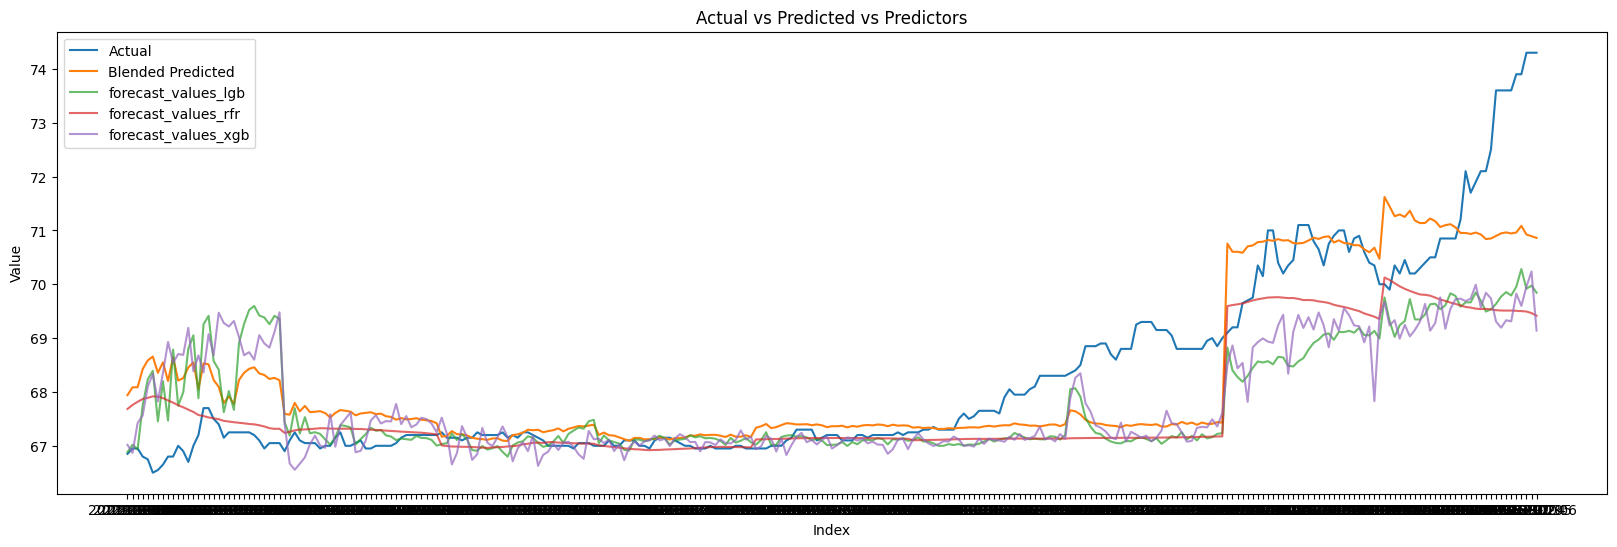

In [34]:
# Train blended Ridge model
ridge_model, ridge_df_train_forecast, ridge_df_train_metrics = train_ridge_regression(
    df=df_blend, 
    target_column='selling_price_actual',
    alpha=alpha, 
    plot_flag=True,
)

In [35]:
# Evaluation metrics
print("Metrics:")
ridge_df_train_metrics

Metrics:


,MSE,MAE,RMSE,MAPE,SMAPE,Forecast Bias
forecast_values_lgb,1.717786,0.894434,1.310643,1.306660,1.294999,-0.50
forecast_values_rfr,1.374191,0.711751,1.172259,1.041975,1.029134,-0.52
forecast_values_xgb,1.722183,0.903252,1.312320,1.319370,1.308326,-0.47
blended_predicted_values,0.914960,0.674758,0.956535,0.982123,0.979383,0.00


### **WLS**

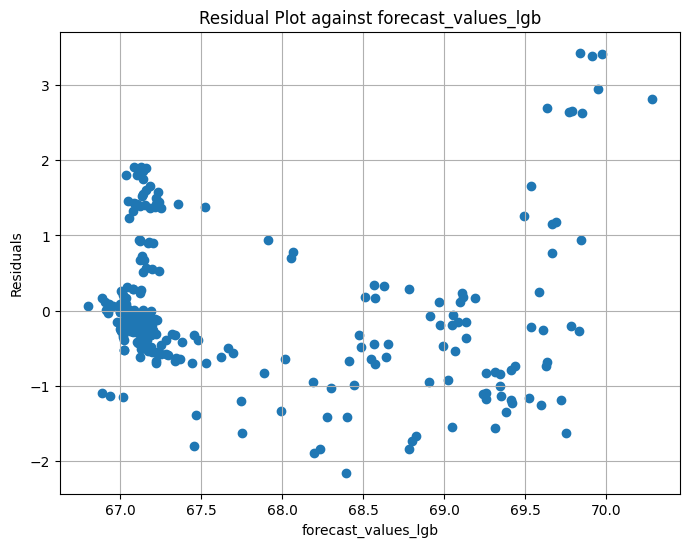

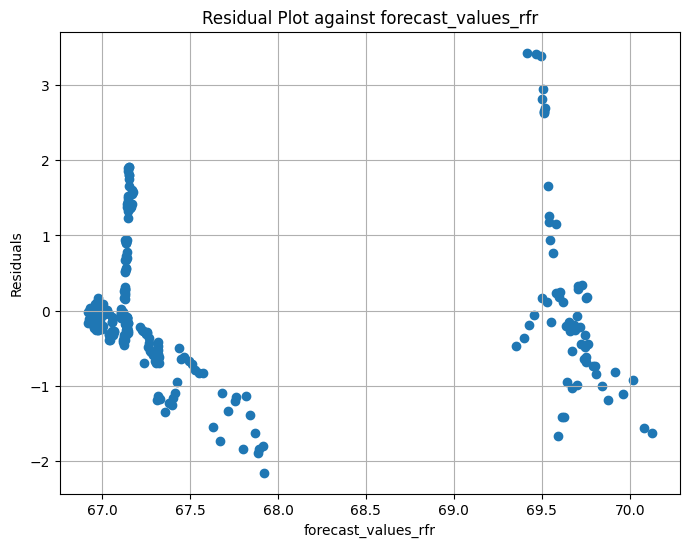

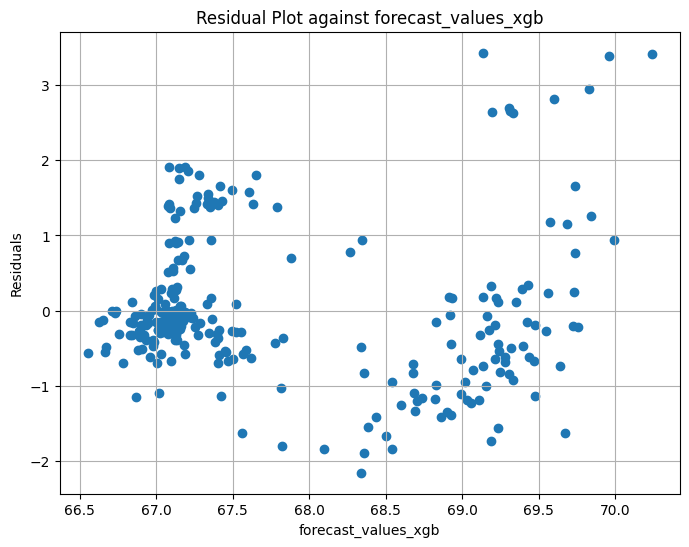

In [36]:
# Choosing the optimal weights
dict_residual_predictor = residual_analysis_with_predictors(
    df=df_blend, 
    target_column='selling_price_actual', 
    square=False
)

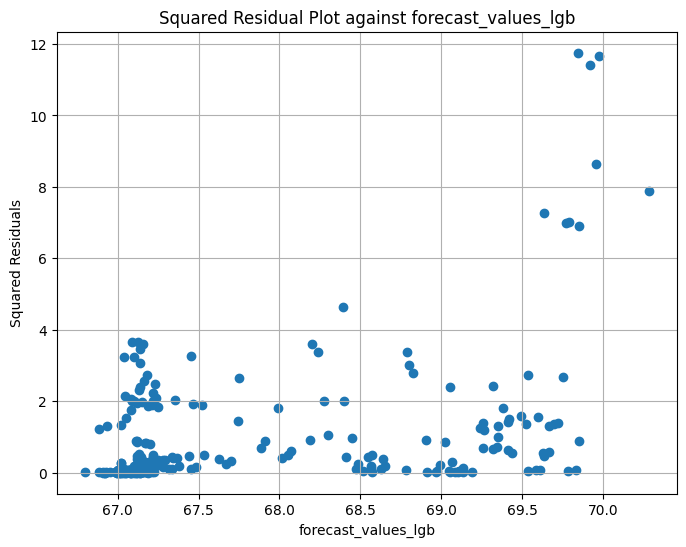

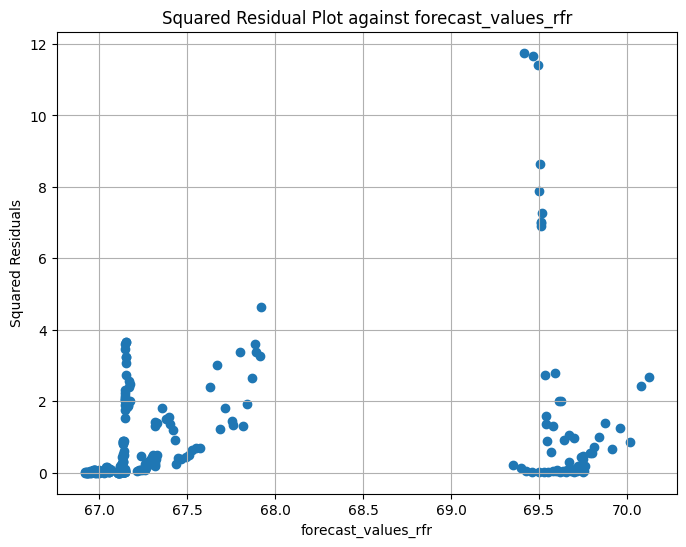

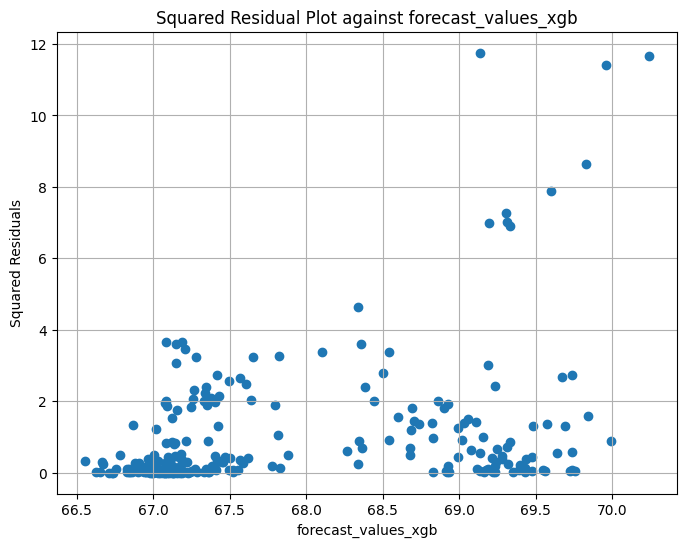

In [38]:
# Choosing the optimal weights
dict_residual_predictor_squared = residual_analysis_with_predictors(
    df=df_blend, 
    target_column='selling_price_actual', 
    square=True
)

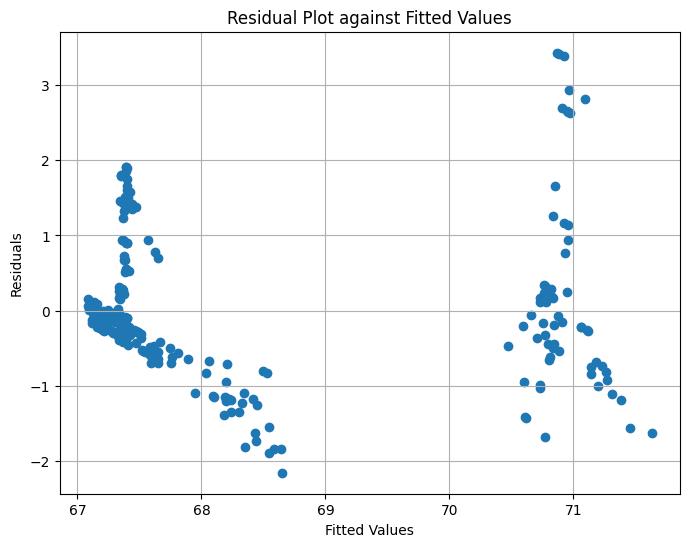

In [37]:
# Choosing the optimal weights
dict_residual_fitted = residual_analysis_with_fitted(
    df=df_blend, 
    target_column='selling_price_actual', 
    square=False
)

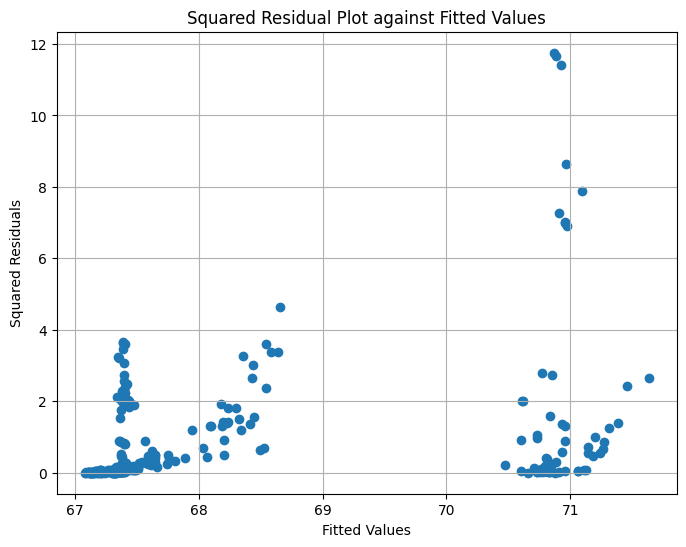

In [39]:
# Choosing the optimal weights
dict_residual_fitted_squared = residual_analysis_with_fitted(
    df=df_blend, 
    target_column='selling_price_actual', 
    square=True
)

In [40]:
weight_fitted = dict_residual_fitted['fitted_values']**2
weight_lgb = dict_residual_predictor['forecast_values_lgb']**2
weight_rfr = dict_residual_predictor['forecast_values_rfr']**2
weight_xgb = dict_residual_predictor['forecast_values_xgb']**2

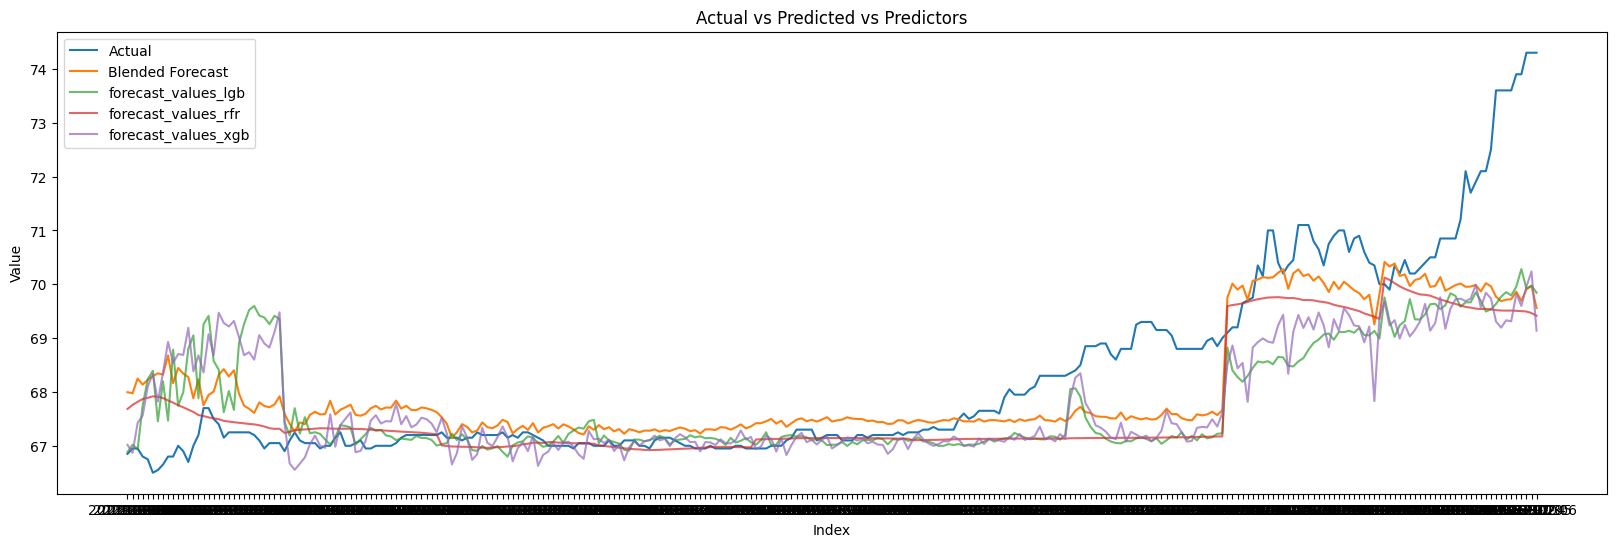

In [41]:
# Train weighted least squares blended model
wlr_model, wlr_df_train_forecast, wlr_df_train_metrics = train_weighted_linear_regression(
    df=df_blend, 
    target_column='selling_price_actual', 
    plot_flag=True,
    weight=weight_xgb
    )

In [42]:
# Display values of error metrics
wlr_df_train_metrics

,MSE,MAE,RMSE,MAPE,SMAPE,Forecast Bias
forecast_values_lgb,1.717786,0.894434,1.310643,1.306660,1.294999,-0.50
forecast_values_rfr,1.374191,0.711751,1.172259,1.041975,1.029134,-0.52
forecast_values_xgb,1.722183,0.903252,1.312320,1.319370,1.308326,-0.47
blended_predicted_values,1.162019,0.728840,1.077970,1.064051,1.056790,-0.16


### **HR**

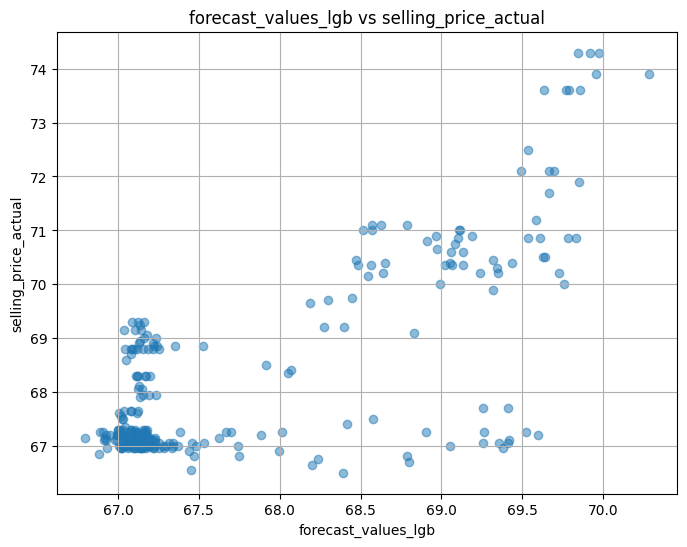

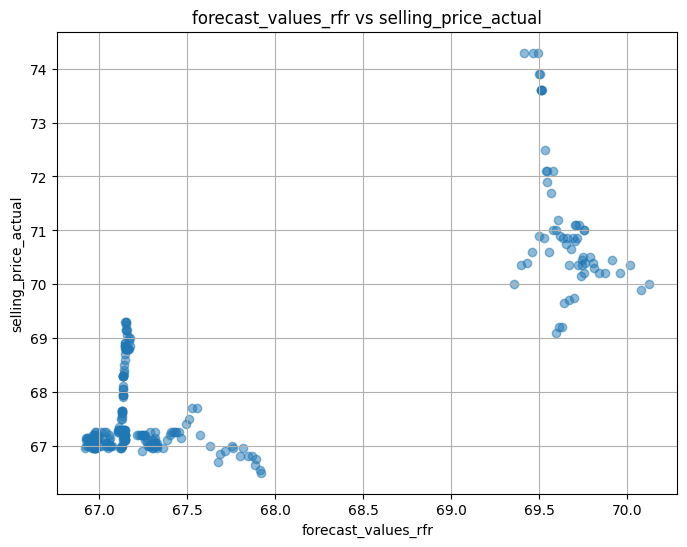

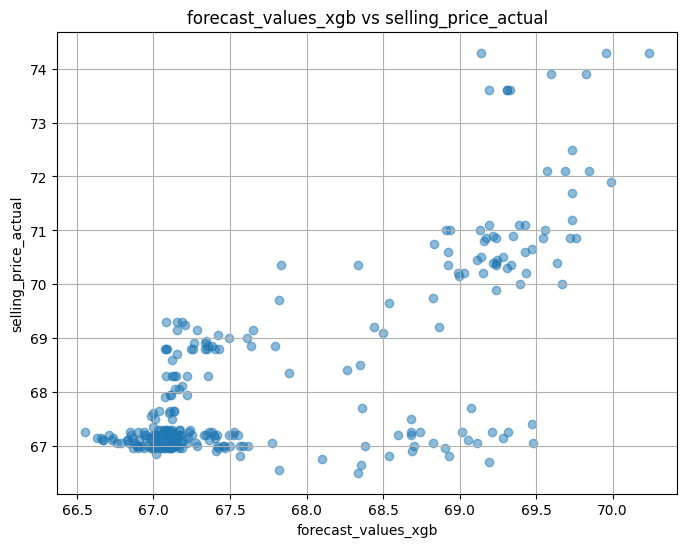

In [43]:
# Plot scatter 
plot_scatter(
    df=df_blend,
    target_column='selling_price_actual'
)

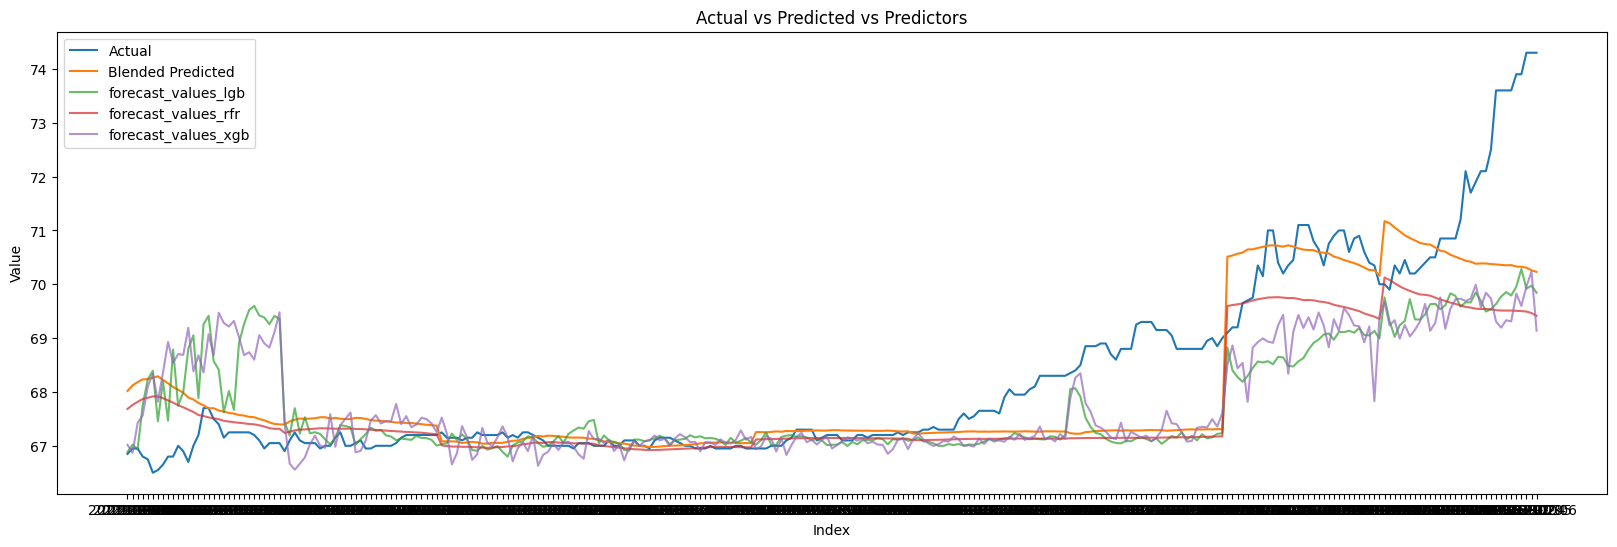

In [44]:
# Train Huber Regression model
hr_model, hr_df_train_forecast, hr_df_train_metrics = train_huber_regression(
    df=df_blend, 
    target_column='selling_price_actual', 
    plot_flag=True
    )

In [45]:
# Display values of error metrics
hr_df_train_metrics

,MSE,MAE,RMSE,MAPE,SMAPE,Forecast Bias
forecast_values_lgb,1.717786,0.894434,1.310643,1.306660,1.294999,-0.50
forecast_values_rfr,1.374191,0.711751,1.172259,1.041975,1.029134,-0.52
forecast_values_xgb,1.722183,0.903252,1.312320,1.319370,1.308326,-0.47
blended_predicted_values,0.995743,0.632766,0.997869,0.923189,0.916556,-0.21


## **Level 1 Make Prediction**

### **Ridge**

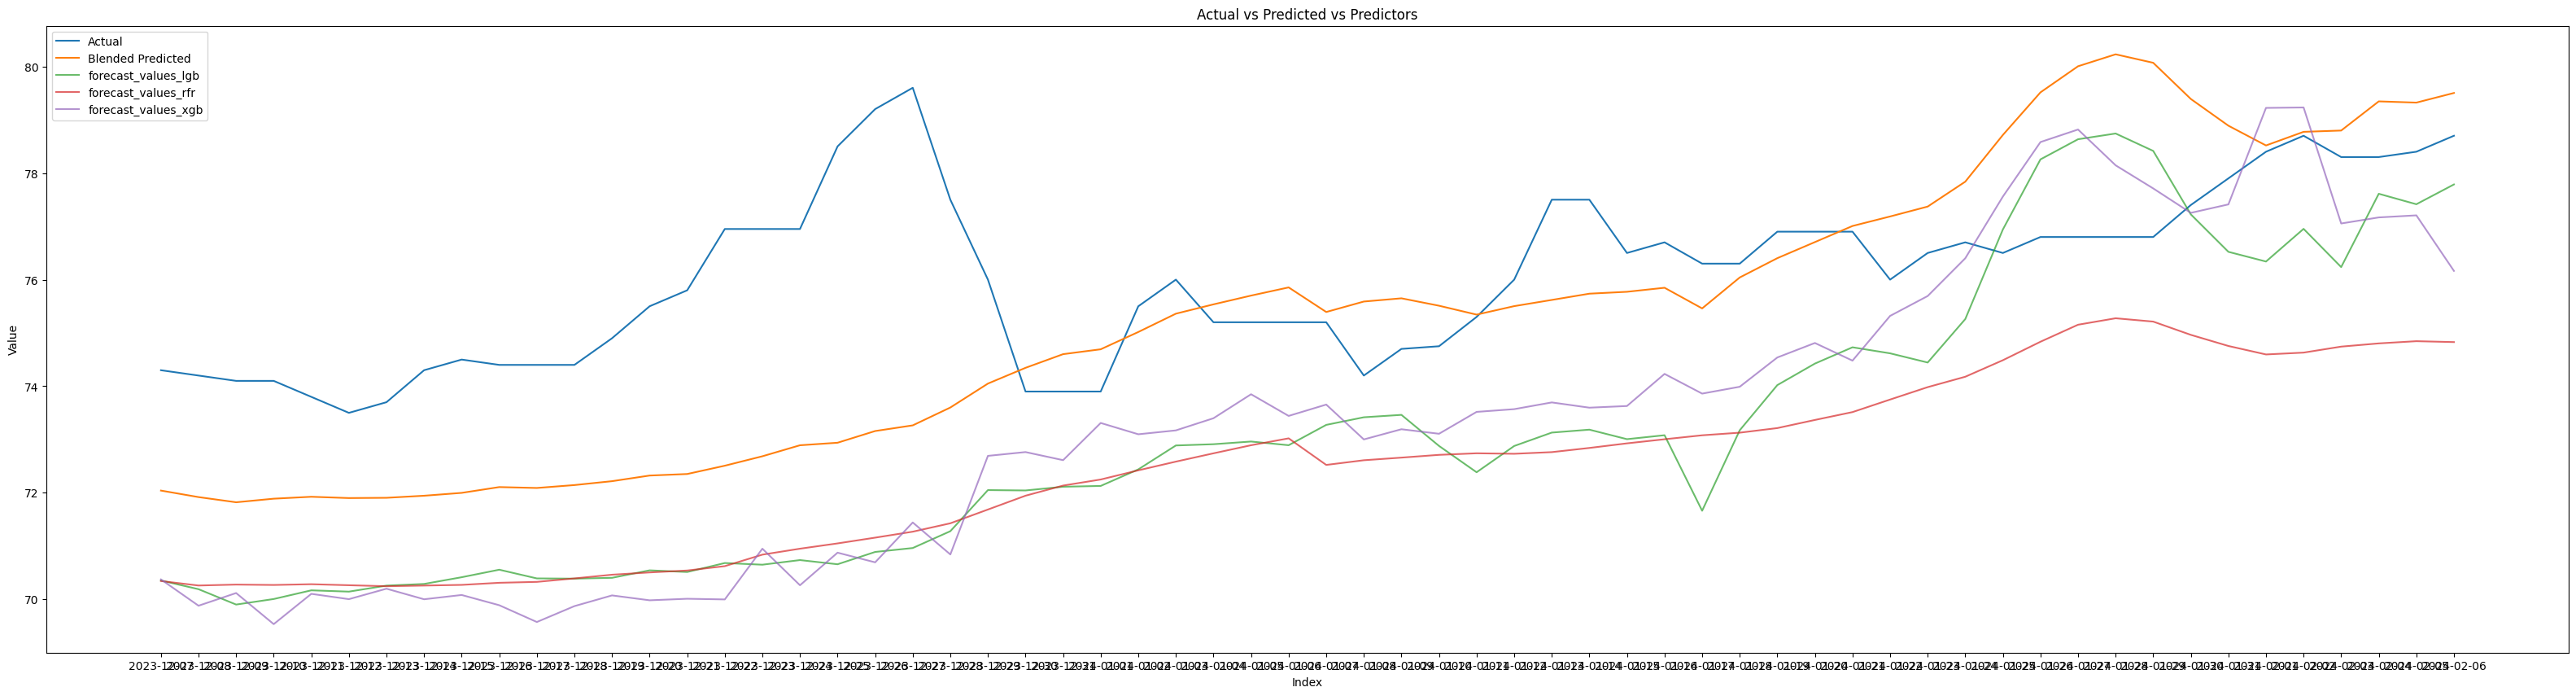

In [46]:
# Ridge Regression make prediction on test set
ridge_test_pred, ridge_test_metrics = make_blended_prediction(
    df=df_test, 
    actual_column='selling_price_actual', 
    model=ridge_model, 
    plot_flag=True
)

In [47]:
# Display values of error metrics
ridge_test_metrics

,MSE,MAE,RMSE,MAPE,SMAPE,Forecast Bias
forecast_values_lgb,13.760731,3.204006,3.709546,4.451843,4.324736,-2.97
forecast_values_rfr,15.366700,3.614973,3.920038,5.015455,4.871208,-3.61
forecast_values_xgb,13.190794,2.983920,3.631913,4.155757,4.033123,-2.71
blended_predicted_values,5.466375,1.803836,2.338028,2.425717,2.392852,-0.79


### **WLS**

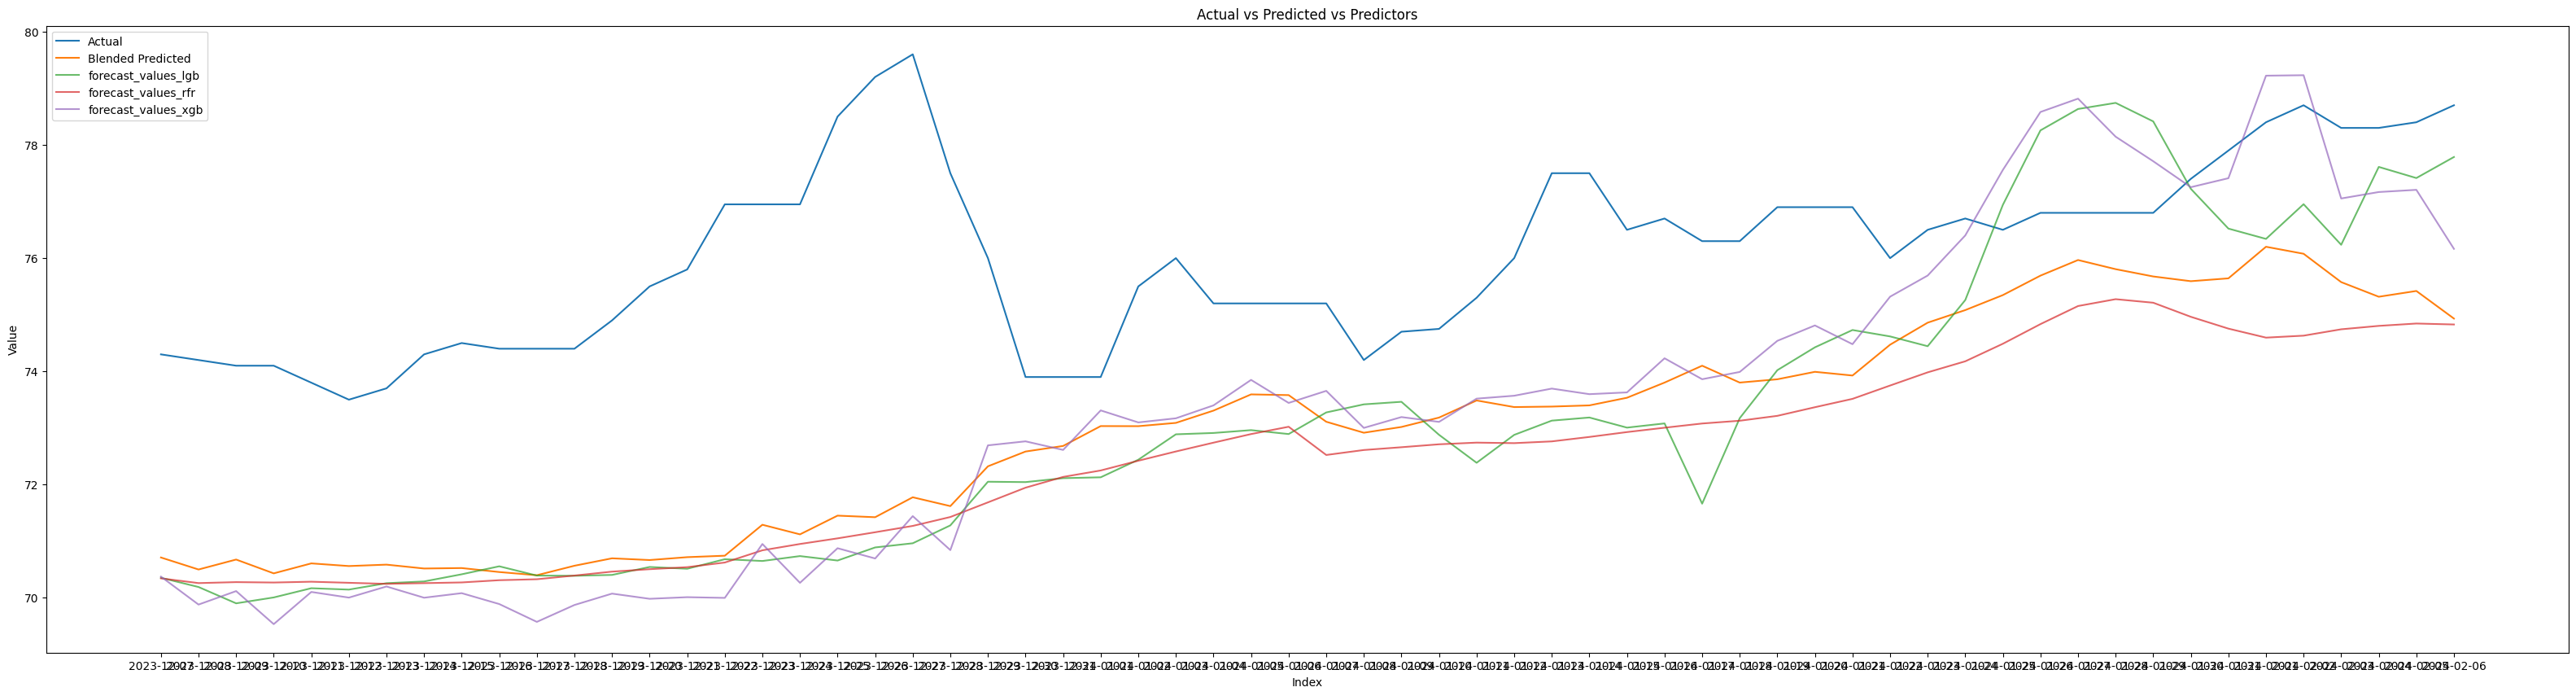

In [49]:
# Create prediction on test set
wlr_test_pred, wlr_test_metrics = make_blended_prediction(
    df=df_test, 
    actual_column='selling_price_actual', 
    model=wlr_model, 
    plot_flag=True
    )

In [50]:
# Display values of error metrics
wlr_test_metrics

,MSE,MAE,RMSE,MAPE,SMAPE,Forecast Bias
forecast_values_lgb,13.760731,3.204006,3.709546,4.451843,4.324736,-2.97
forecast_values_rfr,15.366700,3.614973,3.920038,5.015455,4.871208,-3.61
forecast_values_xgb,13.190794,2.983920,3.631913,4.155757,4.033123,-2.71
blended_predicted_values,12.218279,3.083767,3.495466,4.262261,4.147909,-3.08


### **HR**

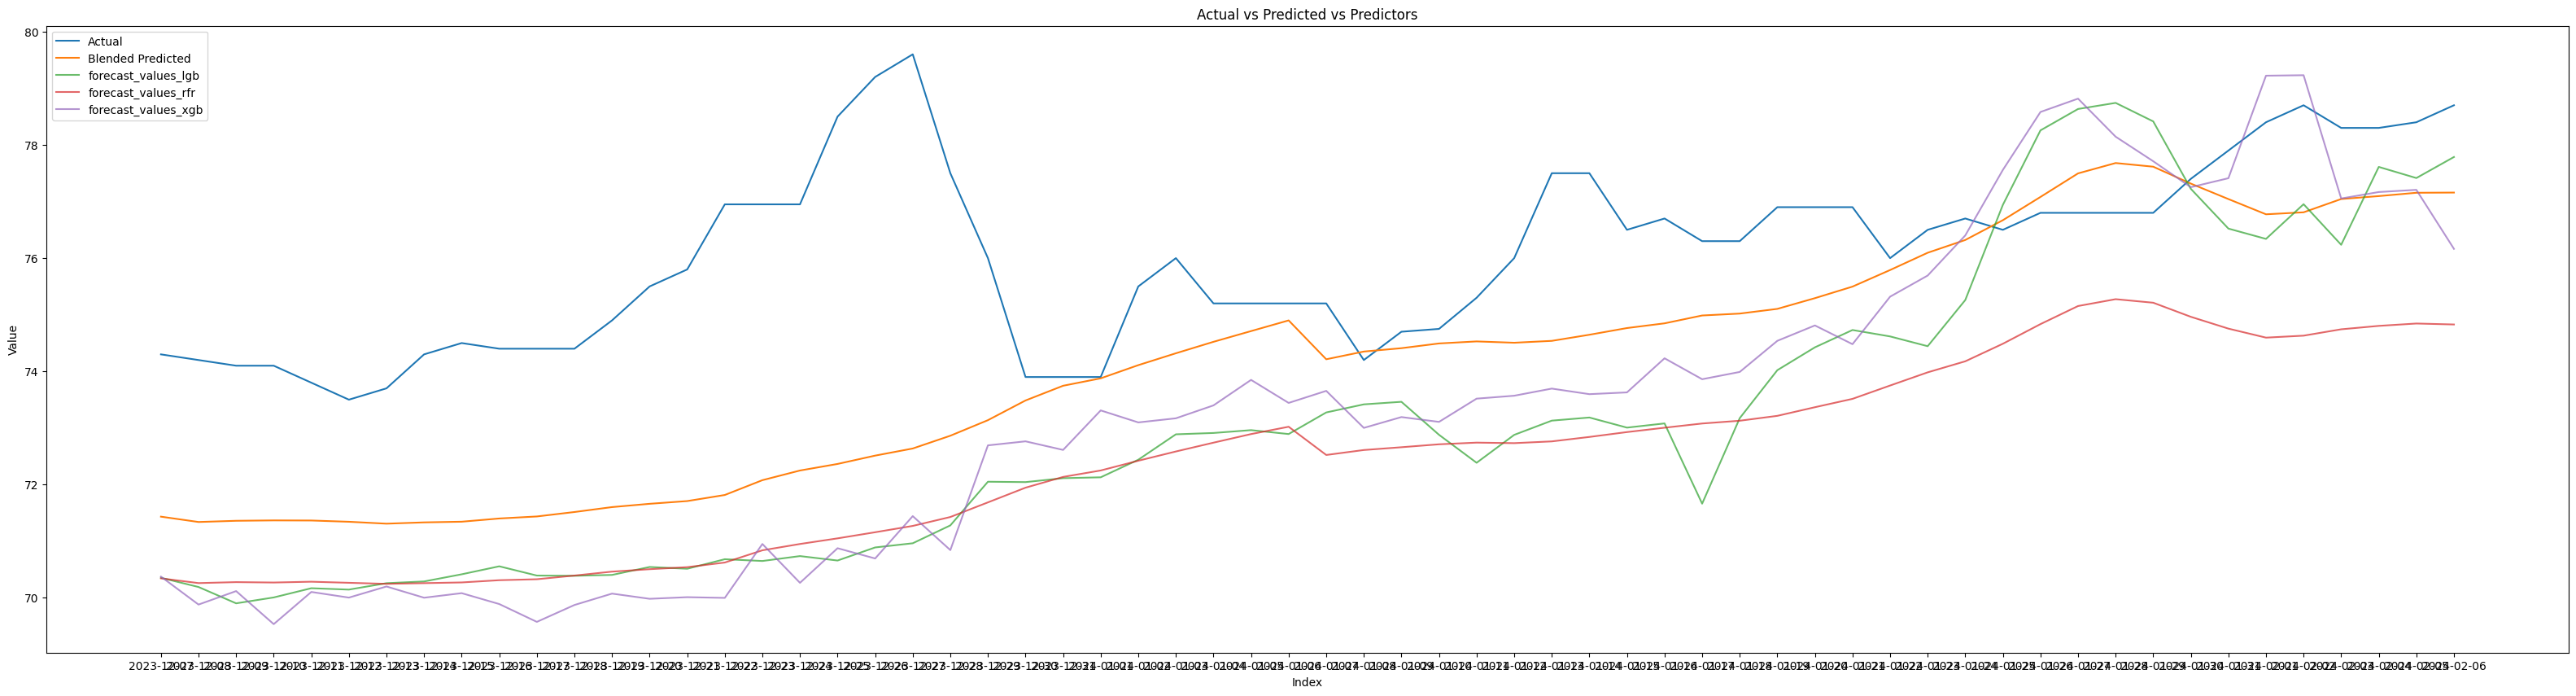

In [51]:
# Create prediction on test set
hr_test_pred, hr_test_metrics = make_blended_prediction(
    df=df_test, 
    actual_column='selling_price_actual', 
    model=hr_model, 
    plot_flag=True
    )

In [52]:
# Display values of error metrics
hr_test_metrics

,MSE,MAE,RMSE,MAPE,SMAPE,Forecast Bias
forecast_values_lgb,13.760731,3.204006,3.709546,4.451843,4.324736,-2.97
forecast_values_rfr,15.366700,3.614973,3.920038,5.015455,4.871208,-3.61
forecast_values_xgb,13.190794,2.983920,3.631913,4.155757,4.033123,-2.71
blended_predicted_values,6.905103,2.028896,2.627756,2.779228,2.716028,-1.93


## **Second level Model**

### **Simple Averaging**

In [53]:
dict_second_level_test = {
    'index': wlr_test_pred.index.tolist(),
    'selling_price_actual': wlr_test_pred['selling_price_actual'].values.tolist(),
    'hr_blended': hr_test_pred['blended_predicted_values'].values.tolist(),
    'wlr_blended': wlr_test_pred['blended_predicted_values'].values.tolist(),
    'ridge_blended': ridge_test_pred['blended_predicted_values'].values.tolist(),
}

df_second_level_test = pd.DataFrame(dict_second_level_test)
df_second_level_test = df_second_level_test.set_index('index')


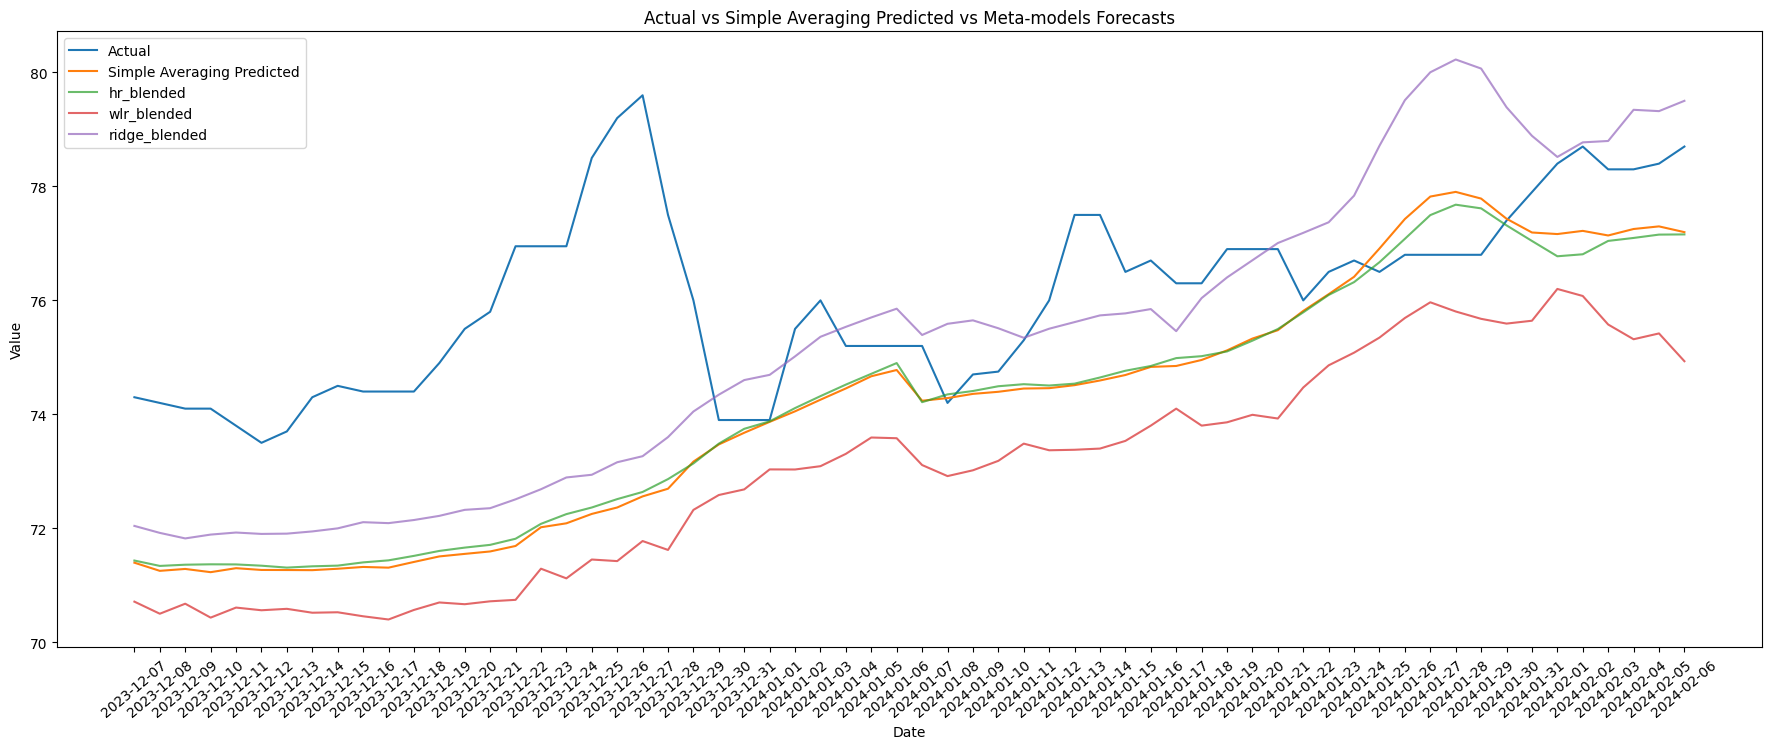

In [54]:
# Simple averaging in the holdout set
second_simple_averaging_test_pred, second_simple_averaging_test_pred_metrics = make_blended_prediction_simple_averaging(
    df=df_second_level_test,
    actual_column='selling_price_actual',
    plot_flag=True
)

In [55]:
# Display values of error metrics
second_simple_averaging_test_pred_metrics

,MSE,MAE,RMSE,MAPE,SMAPE,Forecast Bias
hr_blended,6.905103,2.028896,2.627756,2.779228,2.716028,-1.93
wlr_blended,12.218279,3.083767,3.495466,4.262261,4.147909,-3.08
ridge_blended,5.466375,1.803836,2.338028,2.425717,2.392852,-0.79
simple_averaging_predicted_values,7.183568,2.074180,2.680218,2.844016,2.778539,-1.94


**Plot all forecast series**

In [56]:
# Dataframe contains all forecasts of base learners and meta-models
integrated_forecast_dict = {
    'date': pd.to_datetime(df_test.index),
    'Actual Selling Price': df_test['selling_price_actual'].values,
    'Forecast of Random Forest Regression': df_test['forecast_values_rfr'].values,
    'Forecast of LightGBM': df_test['forecast_values_lgb'].values,
    'Forecast of XGBoost': df_test['forecast_values_xgb'].values,
    'Forecast of Huber Regression': second_simple_averaging_test_pred['hr_blended'].values,
    'Forecast of Weighted Least Squares': second_simple_averaging_test_pred['wlr_blended'].values,
    'Forecast of Ridge Regression': second_simple_averaging_test_pred['ridge_blended'].values,
    'Average Values of Forecasts of Meta-models': second_simple_averaging_test_pred['simple_averaging_predicted_values'].values
}

integrated_df = pd.DataFrame(integrated_forecast_dict)

In [57]:
integrated_df.set_index('date', inplace=True)

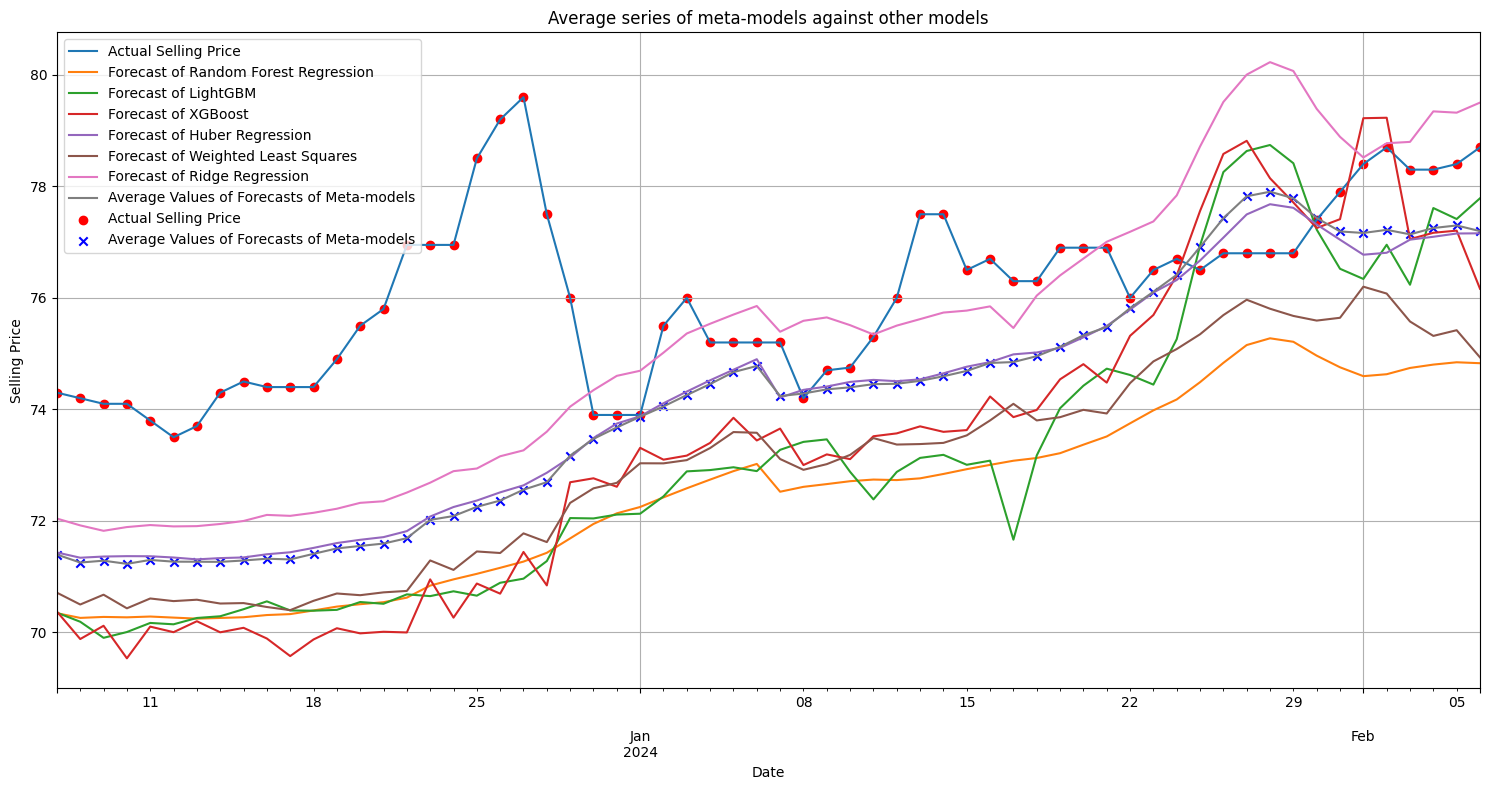

In [58]:
# Plot all forecasts of base learners and meta-models
plt.figure(figsize=(15, 8))
integrated_df.plot(ax=plt.gca())

# Plot dots and 'x' markers for Actual Selling Price
plt.scatter(integrated_df.index, integrated_df['Actual Selling Price'], c='red', marker='o', label='Actual Selling Price')

# Plot dots and 'x' markers for Average Values of Forecasts of Meta-models
plt.scatter(integrated_df.index, integrated_df['Average Values of Forecasts of Meta-models'], c='blue', marker='x', label='Average Values of Forecasts of Meta-models')

plt.title('Average series of meta-models against other models')
plt.xlabel('Date')
plt.ylabel('Selling Price')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [59]:
# Dataframe contains all forecasts of meta-models
simplied_forecast_dict = {
    'date': pd.to_datetime(df_test.index),
    'Actual Selling Price': df_test['selling_price_actual'].values,
    'Forecast of Huber Regression': second_simple_averaging_test_pred['hr_blended'].values,
    'Forecast of Weighted Least Squares': second_simple_averaging_test_pred['wlr_blended'].values,
    'Forecast of Ridge Regression': second_simple_averaging_test_pred['ridge_blended'].values,
    'Average Values of Forecasts of Meta-models': second_simple_averaging_test_pred['simple_averaging_predicted_values'].values
}

simplied_forecast_df = pd.DataFrame(simplied_forecast_dict)
simplied_forecast_df.set_index('date', inplace=True)

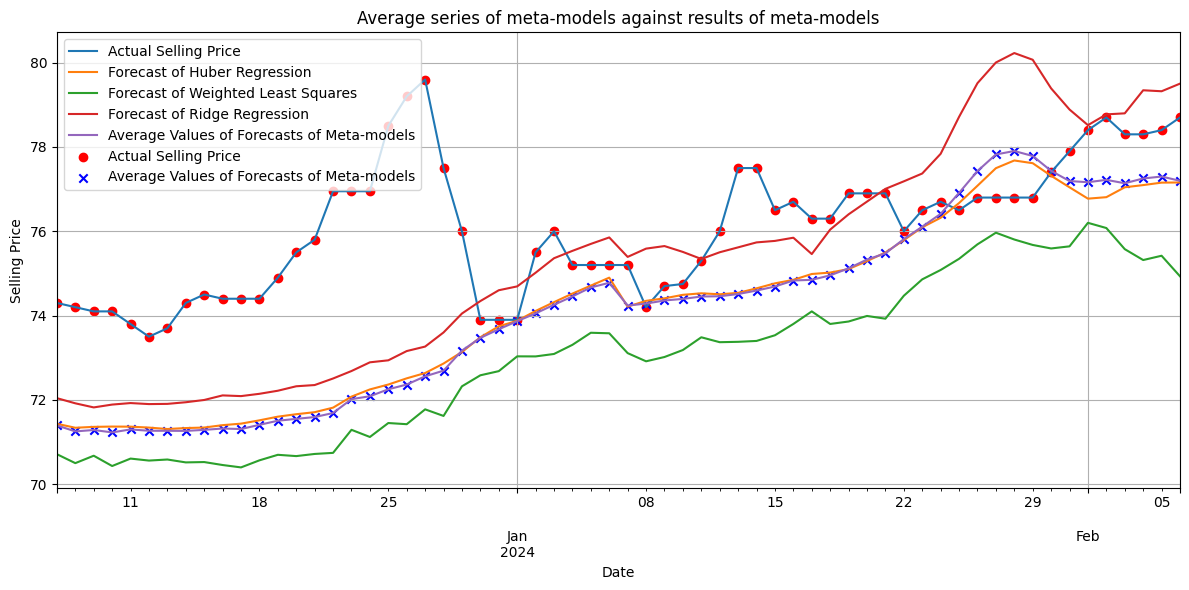

In [60]:
# Plot forecasts of meta-models
plt.figure(figsize=(12, 6))
simplied_forecast_df.plot(ax=plt.gca())

# Plot dots and 'x' markers for Actual Selling Price
plt.scatter(simplied_forecast_df.index, simplied_forecast_df['Actual Selling Price'], c='red', marker='o', label='Actual Selling Price')

# Plot dots and 'x' markers for Average Values of Forecasts of Meta-models
plt.scatter(simplied_forecast_df.index, simplied_forecast_df['Average Values of Forecasts of Meta-models'], c='blue', marker='x', label='Average Values of Forecasts of Meta-models')

plt.title('Average series of meta-models against results of meta-models')
plt.xlabel('Date')
plt.ylabel('Selling Price')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

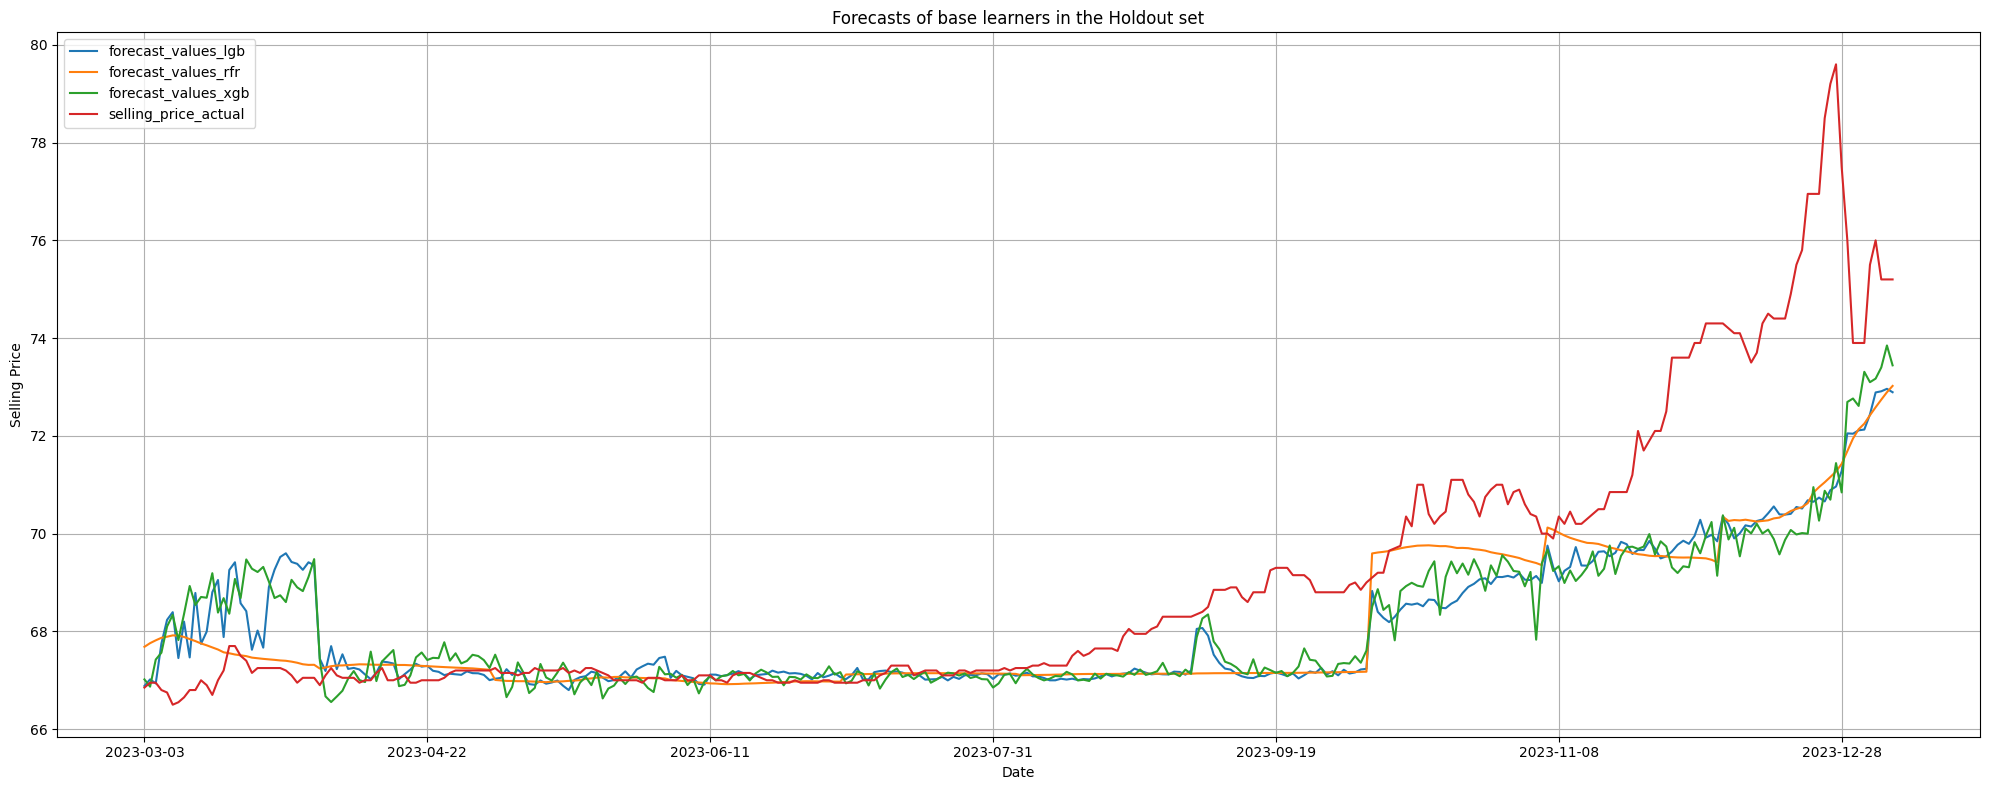

In [61]:
# Plot forecasts of base learners and actual values on Holdout set
plt.figure(figsize=(20, 8))
df_blend_holdout.plot(ax=plt.gca())

# Plot dots and 'x' markers for Actual Selling Price
# plt.scatter(df_blend_holdout.index, df_blend_holdout['selling_price_actual'], c='red', marker='o', label='Actual Selling Price')

# # Plot dots and 'x' markers for Average Values of Forecasts of Meta-models
# plt.scatter(integrated_df.index, integrated_df['Average Values of Forecasts of Meta-models'], c='blue', marker='x', label='Average Values of Forecasts of Meta-models')

plt.title('Forecasts of base learners in the Holdout set')
plt.xlabel('Date')
plt.ylabel('Selling Price')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()